In [56]:
import sys
sys.path.append("../../src")
%load_ext autoreload
%autoreload 2

from typing import Callable, Dict, List
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder



import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns
#from heatmap import heatmap
import statsmodels.formula.api as smf
#import bioinfokit

plt.style.use('ggplot')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [57]:
def preprocess_input_vars_ic_or(df:pd.DataFrame) -> pd.DataFrame:
    df = df.copy()

    ic_date = df["ic_date"]//10000
    ic_date = ic_date.replace(0, np.nan)

    df["age"] = ic_date - (df.date_of_birth//10000)
    
    df["age_gt_45"] = ((ic_date - (df.date_of_birth//10000)\
        .astype(int)) > 45)\
        .apply(lambda x: 1 if x else 0)
    
    df["age_lt_25"] = ((ic_date - (df.date_of_birth//10000)\
        .astype(int)) < 25)\
        .apply(lambda x: 1 if x else 0)
    
    df["gender_female"] = df.sex.transform(lambda x: 1 if x == "F" else 0)

    df = pd.concat(
        [df, pd.get_dummies(df.race, prefix="race").drop("race_W", axis=1)],
        axis=1
    )
    
    df["prior_commits"] = df.ic_prior_commits

    df["escape_hist_1"] = df.ic_escpe_hist_1.transform(
        lambda x: 1 if str(x) == "X" else 0
    )
    df["escape_hist_2"] = df.ic_escpe_hist_2.transform(
        lambda x: 1 if str(x) == "X" else 0
    )
    df["escape_hist_3"] = df.ic_escpe_hist_3.transform(
        lambda x: 1 if str(x) == "X" else 0
    )
    df["escape_hist_4"] = df.ic_escpe_hist_4.transform(
        lambda x: 1 if str(x) == "X" else 0
    )
    df["escape_hist_5"] = df.ic_escpe_hist_5.transform(
        lambda x: 1 if str(x) == "X" else 0
    )

    df["escape_hist"] = (
        df["escape_hist_1"] +
        df["escape_hist_2"] +
        df["escape_hist_3"] +
        df["escape_hist_4"] +
        df["escape_hist_5"]
    )

    df = pd.concat(
        [
            df,
            pd.get_dummies(df.ic_mrtl_stat_fr_cl, prefix="mrt_stat")\
                .drop(["mrt_stat_SIN", "mrt_stat_UNK"], axis=1)
        ],
        axis=1
    )

    df["maritial_status"] = LabelEncoder().fit_transform(df["ic_mrtl_stat_fr_cl"])

    df["employed"] = df.ic_employ_ind.fillna(0).replace("X", 1)

    df["race"] = LabelEncoder().fit_transform(df["race"])
    
    
    temp_var = "prob_alcohol"
    df[temp_var] = df[temp_var].replace(' ', 0)    
    df[temp_var] = df[temp_var].replace('  ', 0)    
    df[temp_var] = df[temp_var].replace('NV', 0)
    df[temp_var] = df[temp_var].replace(np.nan, 0)
    df[temp_var] = df[temp_var].replace('V ', 1)
    
    temp_var = "prob_drugs"
    df[temp_var] = df[temp_var].replace(' ', 0)    
    df[temp_var] = df[temp_var].replace('  ', 0)    
    df[temp_var] = df[temp_var].replace('NV', 0)    
    df[temp_var] = df[temp_var].replace('V ', 1)
    
    temp_var = "prob_assault"
    df[temp_var] = df[temp_var].replace(' ', 0)    
    df[temp_var] = df[temp_var].replace('  ', 0)    
    df[temp_var] = df[temp_var].replace('NV', 0)    
    df[temp_var] = df[temp_var].replace('V ', 1)
    

    temp_var = "prob_sexual"
    df[temp_var] = df[temp_var].replace(' ', 0)    
    df[temp_var] = df[temp_var].replace('  ', 0)    
    df[temp_var] = df[temp_var].replace('NV', 0)    
    df[temp_var] = df[temp_var].replace('V ', 1)
    

    temp_var = "prob_psyco"
    df[temp_var] = df[temp_var].replace(' ', 0)    
    df[temp_var] = df[temp_var].replace('  ', 0)    
    df[temp_var] = df[temp_var].replace('NV', 0)    
    df[temp_var] = df[temp_var].replace('V ', 1)
    
    temp_var = "prob_suicide"
    df[temp_var] = df[temp_var].replace(' ', 0)    
    df[temp_var] = df[temp_var].replace('  ', 0)    
    df[temp_var] = df[temp_var].replace('NV', 0)    
    df[temp_var] = df[temp_var].replace('V ', 1)
    
    temp_var = "prob_escape"
    df[temp_var] = df[temp_var].replace(' ', 0)    
    df[temp_var] = df[temp_var].replace('  ', 0)    
    df[temp_var] = df[temp_var].replace('NV', 0)    
    df[temp_var] = df[temp_var].replace('V ', 1)
    

    df["problematic_conditions"] = (df["prob_escape"] 
                                    + df["prob_alcohol"] 
                                    + df["prob_assault"]
                                    + df["prob_drugs"] 
                                    + df["prob_psyco"]
                                    + df["prob_sexual"]
                                    + df["prob_suicide"])
    
    temp_var = "problematic_offenses"
    df[temp_var] = df[temp_var].replace(' ', 0)    
    df[temp_var] = df[temp_var].replace('N', 0)    
    df[temp_var] = df[temp_var].replace('Y', 1)    
    
    return df


## Overrides during initial classification

In [58]:
df = pd.read_csv("../data/initial_custody_2017_gsprs.csv", low_memory=False)

df['high_ic_instit_adj'] = np.where(df['ic_institut_adj']>2, 1, 0)
df['ic_override_up'] = np.where(df['ic_ovride_cust_lvl']-df['ic_custdy_level']>0,1,0)
df['high_ic'] = np.where(df['ic_custdy_level']>3, 1, 0)

data = preprocess_input_vars_ic_or(df)

data_ic_or = data[
    [
        "gender_female",
        "age_gt_45",
        "age_lt_25",
        "race_B",
        "race_A",
        "race_H",
        #"race_I",
        "race_O",
        "off_1_prs_max",
        "off_1_gs_max",
        "ic_custdy_level",
        "prior_commits",
        "ic_institut_adj",
        "escape_hist_1",
        #"escape_hist_2",
        #"escape_hist_3",
        #"escape_hist_4",
        "escape_hist_5",
        "mrt_stat_DIV",
        "mrt_stat_SEP",
        "mrt_stat_MAR",
        "mrt_stat_WID",
        "employed",
        "problematic_offenses",
        "problematic_conditions",
        "ic_override_up"
    ]
]

data_ic_or = data_ic_or.dropna()

In [59]:
np.sum(data_ic_or[data_ic_or['ic_override_up']==1]['mrt_stat_WID'])

8

In [60]:
data_ic_or['ic_override_up'].value_counts()

0    13563
1      253
Name: ic_override_up, dtype: int64

In [61]:
X = data_ic_or.loc[:, data_ic_or.columns != 'ic_override_up']
y = data_ic_or.loc[:, data_ic_or.columns == 'ic_override_up']

### Balance classes

In [62]:
from imblearn.over_sampling import SMOTE

os = SMOTE(random_state=0)

X_os, y_os = os.fit_resample(X, y)

### Recursive feature elimination

In [63]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression


logreg = LogisticRegression(max_iter=2000) # increase the number of iterations to get convergence

rfe = RFE(logreg, n_features_to_select=4, step=1)
rfe = rfe.fit(X_os, y_os.values.ravel())

zz= list(zip(X_os.columns,list(rfe.support_)))

features = [a for (a,b) in zz if b]

features


['gender_female', 'race_A', 'race_O', 'mrt_stat_WID']

In [64]:
#ll.append('race_B')
#ll.append('gender_female')
#ll.append('problematic_conditions')
#ll.append('problematic_offenses')
#ll.append('age_lt_25')
#ll.append('age_gt_45')
#ll.append('ic_institut_adj')

#X = X[ll]

logit_model=sm.Logit(y,X.astype(float))
result=logit_model.fit(solver="lbfgs",maxiter=10000)
print(result.summary2())
print("+")
model_odds = pd.DataFrame(np.exp(result.params), columns= ['OR'])
model_odds['z-value']= result.pvalues
model_odds[['2.5%', '97.5%']] = np.exp(result.conf_int())
print(model_odds)

Optimization terminated successfully.
         Current function value: 0.090641
         Iterations 9
                            Results: Logit
Model:                 Logit              Pseudo R-squared:   0.008    
Dependent Variable:    ic_override_up     AIC:                2546.6026
Date:                  2022-02-04 23:39   BIC:                2704.8079
No. Observations:      13816              Log-Likelihood:     -1252.3  
Df Model:              20                 LL-Null:            -1262.7  
Df Residuals:          13795              LLR p-value:        0.40699  
Converged:             1.0000             Scale:              1.0000   
No. Iterations:        9.0000                                          
-----------------------------------------------------------------------
                        Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
-----------------------------------------------------------------------
gender_female          -0.4765   0.3922  -1.2150 0.2244 -1.2451

Accuracy of logistic regression classifier on test set: 0.76
[[3119  951]
 [  42   33]]
              precision    recall  f1-score   support

           0       0.99      0.77      0.86      4070
           1       0.03      0.44      0.06        75

    accuracy                           0.76      4145
   macro avg       0.51      0.60      0.46      4145
weighted avg       0.97      0.76      0.85      4145



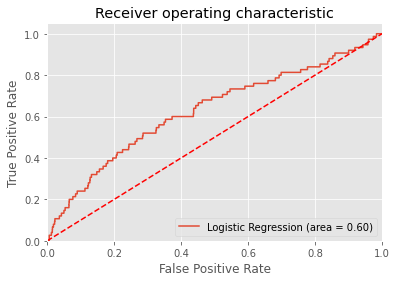

In [65]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics
import matplotlib.pyplot as plt

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

X_train_os, y_train_os = os.fit_resample(X_train, y_train)

logreg = LogisticRegression(max_iter=2000)
logreg.fit(X_train_os, y_train_os.values.ravel())

y_pred = logreg.predict(X_test)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test, y_test)))

from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test, y_pred)
print(confusion_matrix)

from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
logit_roc_auc = roc_auc_score(y_test, logreg.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, logreg.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

### IC override SVM

In [66]:
#We ommitted escape histories 2, 3 and 4 because they were highly correlated with escape history 1
#and because we want to know if they're frequent escapees or not, and not necessarily how many times

from sklearn.metrics import accuracy_score





#applying Support Vector Classifier 
#fitting kernel SVM to training dataset
from sklearn.svm import SVC
classifier_df = SVC(kernel = 'linear' , random_state = 0)
classifier_df.fit(X_train_os,y_train_os)

#predicting test data result
y_pred = classifier_df.predict(X_test)


#setting up accuracy score

acc = accuracy_score(y_test,y_pred) *100
print("Accuracy for our dataset in predicting test data is : {:.2f}%".format(acc))

/home/ncr006/anaconda2/envs/psapm/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


Accuracy for our dataset in predicting test data is : 76.19%


In [67]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      0.77      0.86      4070
           1       0.03      0.43      0.06        75

    accuracy                           0.76      4145
   macro avg       0.51      0.60      0.46      4145
weighted avg       0.97      0.76      0.85      4145



### IC override Neural Network

In [24]:
from sklearn.neural_network import MLPClassifier

clf = MLPClassifier(solver='lbfgs', 
                    alpha=1e-5,
                    hidden_layer_sizes=(14,), 
                    random_state=1, 
                    max_iter=10000)

clf.fit(X_train_os, y_train_os)

y_pred = clf.predict(X_test)

acc = accuracy_score(y_test,y_pred) *100
print("Accuracy for our dataset in predicting test data is : {:.2f}%".format(acc))

/home/ncr006/anaconda2/envs/psapm/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


Accuracy for our dataset in predicting test data is : 83.52%


In [25]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      0.84      0.91      4070
           1       0.04      0.31      0.06        75

    accuracy                           0.84      4145
   macro avg       0.51      0.58      0.49      4145
weighted avg       0.97      0.84      0.89      4145



### IC override Random Forest

In [22]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix

clf = RandomForestClassifier(n_estimators = 100, criterion = 'gini', random_state = 0)
clf.fit(X_train_os, y_train_os)

from sklearn.metrics import accuracy_score

y_pred = clf.predict(X_test)

acc = accuracy_score(y_test,y_pred) *100
print("Accuracy for our dataset in predicting test data is : {:.2f}%".format(acc))

<ipython-input-22-973a04dff940>:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  clf.fit(X_train_os, y_train_os)


Accuracy for our dataset in predicting test data is : 97.35%


In [23]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.99      0.99      4070
           1       0.05      0.03      0.04        75

    accuracy                           0.97      4145
   macro avg       0.52      0.51      0.51      4145
weighted avg       0.97      0.97      0.97      4145



## Overrides during reclassification

In [26]:
def preprocess_input_vars_re_or(df:pd.DataFrame) -> pd.DataFrame:
    df = df.copy()

    re_date = df["re_de_year"]
    re_date = re_date.replace(0, np.nan)
    
    df["re_ovride_cust_lvl"] = df["re_ovride_cust_lvl"].replace(" ", np.nan)
    df["re_ovride_cust_lvl"] = df["re_ovride_cust_lvl"].replace("", np.nan)
    
    df["re_ovride_cust_lvl"] = df["re_ovride_cust_lvl"].astype(float)
    
    
    df["age"] = re_date - (df.date_of_birth//10000)

    df["age_gt_45"] = ((re_date - (df.date_of_birth//10000)\
        .astype(int)) > 45)\
        .apply(lambda x: 1 if x else 0)
    
    df["age_lt_25"] = ((re_date - (df.date_of_birth//10000)\
        .astype(int)) < 25)\
        .apply(lambda x: 1 if x else 0)
    
    df["gender_female"] = df.sex.transform(lambda x: 1 if x == "F" else 0)

    df = pd.concat(
        [df, pd.get_dummies(df.race, prefix="race").drop("race_W", axis=1)],
        axis=1
    )
    
    df["prior_commits"] = df.ic_prior_commits

    df["re_escp_hist_1"] = df.re_escp_hist_1.transform(
        lambda x: 1 if str(x) == "X" else 0
    )
    df["re_escp_hist_2"] = df.re_escp_hist_2.transform(
        lambda x: 1 if str(x) == "X" else 0
    )
    df["re_escp_hist_3"] = df.re_escp_hist_3.transform(
        lambda x: 1 if str(x) == "X" else 0
    )
    df["re_escp_hist_4"] = df.re_escp_hist_4.transform(
        lambda x: 1 if str(x) == "X" else 0
    )
    df["re_escp_hist_5"] = df.re_escp_hist_5.transform(
        lambda x: 1 if str(x) == "X" else 0
    )

    df["escape_hist"] = (
        df["re_escp_hist_1"] +
        df["re_escp_hist_2"] +
        df["re_escp_hist_3"] +
        df["re_escp_hist_4"] +
        df["re_escp_hist_5"]
    )
    
    
    df = pd.concat(
        [
            df,
            pd.get_dummies(df.ic_mrtl_stat_fr_cl, prefix="mrt_stat")\
                .drop(["mrt_stat_SIN", "mrt_stat_UNK"], axis=1)
        ],
        axis=1
    )

    df["marital_status"] = LabelEncoder().fit_transform(df["ic_mrtl_stat_fr_cl"])

    df["race"] = LabelEncoder().fit_transform(df["race"])
    

    df["employed"] = df.ic_employ_ind.fillna(0).replace("X", 1)
    
    
    temp_var = "prob_alcohol"
    df[temp_var] = df[temp_var].replace(' ', 0)    
    df[temp_var] = df[temp_var].replace('  ', 0)    
    df[temp_var] = df[temp_var].replace('NV', 0)
    df[temp_var] = df[temp_var].replace(np.nan, 0)
    df[temp_var] = df[temp_var].replace('V ', 1)
    
    temp_var = "prob_drugs"
    df[temp_var] = df[temp_var].replace(' ', 0)    
    df[temp_var] = df[temp_var].replace('  ', 0)    
    df[temp_var] = df[temp_var].replace('NV', 0)    
    df[temp_var] = df[temp_var].replace('V ', 1)
    
    temp_var = "prob_assault"
    df[temp_var] = df[temp_var].replace(' ', 0)    
    df[temp_var] = df[temp_var].replace('  ', 0)    
    df[temp_var] = df[temp_var].replace('NV', 0)    
    df[temp_var] = df[temp_var].replace('V ', 1)
    

    temp_var = "prob_sexual"
    df[temp_var] = df[temp_var].replace(' ', 0)    
    df[temp_var] = df[temp_var].replace('  ', 0)    
    df[temp_var] = df[temp_var].replace('NV', 0)    
    df[temp_var] = df[temp_var].replace('V ', 1)
    

    temp_var = "prob_psyco"
    df[temp_var] = df[temp_var].replace(' ', 0)    
    df[temp_var] = df[temp_var].replace('  ', 0)    
    df[temp_var] = df[temp_var].replace('NV', 0)    
    df[temp_var] = df[temp_var].replace('V ', 1)
    
    temp_var = "prob_suicide"
    df[temp_var] = df[temp_var].replace(' ', 0)    
    df[temp_var] = df[temp_var].replace('  ', 0)    
    df[temp_var] = df[temp_var].replace('NV', 0)    
    df[temp_var] = df[temp_var].replace('V ', 1)
    
    temp_var = "prob_escape"
    df[temp_var] = df[temp_var].replace(' ', 0)    
    df[temp_var] = df[temp_var].replace('  ', 0)    
    df[temp_var] = df[temp_var].replace('NV', 0)    
    df[temp_var] = df[temp_var].replace('V ', 1)
    

    df["problematic_conditions"] = (df["prob_escape"] 
                                    + df["prob_alcohol"] 
                                    + df["prob_assault"]
                                    + df["prob_drugs"] 
                                    + df["prob_escape"] 
                                    + df["prob_psyco"]
                                    + df["prob_sexual"]
                                    + df["prob_suicide"])
    
    temp_var = "problematic_offenses"
    df[temp_var] = df[temp_var].replace(' ', 0)    
    df[temp_var] = df[temp_var].replace('N', 0)    
    df[temp_var] = df[temp_var].replace('Y', 1)    
    
    #df['re_ovride_cust_lvl'] = df['re_ovride_cust_lvl'].replace(np.nan, np.n)
    #df['re_custody_level'] = df['re_ovride_cust_lvl'].replace(np.nan, 0)
    return df


In [27]:
df = pd.read_csv("../data/re_custody_2017_gsprs.csv", low_memory=False)

df['re_ovride_cust_lvl'] = df['re_ovride_cust_lvl'].replace(' ', np.nan)



In [28]:
df['re_override_up'] = np.where(df['re_ovride_cust_lvl'].astype(float)-df['re_custody_level']>0,1,0)
df['high_re'] = np.where(df['re_custody_level']>3, 1, 0)



In [29]:
data = preprocess_input_vars_re_or(df)



In [30]:
data_re_or = data[
    [
        "gender_female",
        "age_gt_45",
        "age_lt_25",
        "race_B",
        "race_A",
        "race_H",
        "race_I",
        "race_O",
        "off_1_prs_max",
        "off_1_gs_max",
        "prior_commits",
        "re_discip_reports",
        "re_escp_hist_1",
        #"re_escp_hist_2",
        #"re_escp_hist_3",
        #"re_escp_hist_4",
        "re_escp_hist_5",
        "mrt_stat_DIV",
        "mrt_stat_SEP",
        "mrt_stat_MAR",
        "mrt_stat_WID",
        "employed",
        "problematic_offenses",
        "problematic_conditions",
        "re_override_up",
        "re_custody_level"
    ]
]

data_re_or = data_re_or.dropna()

In [31]:
data_re_or['re_override_up'].value_counts()

0    13746
1     2797
Name: re_override_up, dtype: int64

In [32]:
X = data_re_or.loc[:, data_re_or.columns != 're_override_up']
y = data_re_or.loc[:, data_re_or.columns == 're_override_up']

### Balance classes

In [33]:
os = SMOTE(random_state=0)

X_os, y_os = os.fit_resample(X,y)

In [34]:
X.columns

Index(['gender_female', 'age_gt_45', 'age_lt_25', 'race_B', 'race_A', 'race_H',
       'race_I', 'race_O', 'off_1_prs_max', 'off_1_gs_max', 'prior_commits',
       're_discip_reports', 're_escp_hist_1', 're_escp_hist_5', 'mrt_stat_DIV',
       'mrt_stat_SEP', 'mrt_stat_MAR', 'mrt_stat_WID', 'employed',
       'problematic_offenses', 'problematic_conditions', 're_custody_level'],
      dtype='object')

### RFE

In [35]:
logreg = LogisticRegression(max_iter=500) # increase the number of iterations to get convergence

rfe = RFE(logreg, n_features_to_select=4, step=1)
rfe = rfe.fit(X_os, y_os.values.ravel())

zz= list(zip(X_os.columns,list(rfe.support_)))

ll = [a for (a,b) in zz if b]

ll

['gender_female', 'age_lt_25', 'mrt_stat_SEP', 'problematic_offenses']

In [36]:
#ll.append('race_B')
#ll.append('problematic_conditions')
#ll.append('age_gt_45')
#ll.append('re_discip_reports')

#X = X[ll]

logit_model=sm.Logit(y,X.astype(float))
result=logit_model.fit()
print(result.summary2())

model_odds = pd.DataFrame(np.exp(result.params), columns= ['OR'])
model_odds['z-value']= result.pvalues
model_odds[['2.5%', '97.5%']] = np.exp(result.conf_int())
print(model_odds)

Optimization terminated successfully.
         Current function value: 0.290415
         Iterations 9
                            Results: Logit
Model:                 Logit              Pseudo R-squared:   0.361    
Dependent Variable:    re_override_up     AIC:                9652.6819
Date:                  2022-02-03 23:17   BIC:                9822.3837
No. Observations:      16543              Log-Likelihood:     -4804.3  
Df Model:              21                 LL-Null:            -7517.4  
Df Residuals:          16521              LLR p-value:        0.0000   
Converged:             1.0000             Scale:              1.0000   
No. Iterations:        9.0000                                          
-----------------------------------------------------------------------
                        Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
-----------------------------------------------------------------------
gender_female          -0.8013   0.1930  -4.1517 0.0000 -1.1796

Accuracy of logistic regression classifier on test set: 0.81
[[3331  756]
 [ 173  703]]
              precision    recall  f1-score   support

           0       0.95      0.82      0.88      4087
           1       0.48      0.80      0.60       876

    accuracy                           0.81      4963
   macro avg       0.72      0.81      0.74      4963
weighted avg       0.87      0.81      0.83      4963



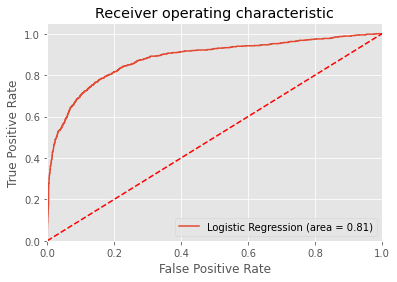

In [37]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=2)



X_train_os, y_train_os = os.fit_resample(X_train, y_train)

logreg = LogisticRegression(max_iter=2000)
logreg.fit(X_train_os, y_train_os.values.ravel())

y_pred = logreg.predict(X_test)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test, y_test)))

from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test, y_pred)
print(confusion_matrix)

from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
logit_roc_auc = roc_auc_score(y_test, logreg.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, logreg.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

### RE override with SVM

In [53]:
#We ommitted escape histories 2, 3 and 4 because they were highly correlated with escape history 1
#and because we want to know if they're frequent escapees or not, and not necessarily how many times

from sklearn.metrics import accuracy_score





#applying Support Vector Classifier 
#fitting kernel SVM to training dataset
from sklearn.svm import SVC
classifier_df = SVC(kernel = 'linear' , random_state = 0)
classifier_df.fit(X_train_os,y_train_os)

#predicting test data result
y_pred = classifier_df.predict(X_test)


#setting up accuracy score

acc = accuracy_score(y_test,y_pred) *100
print("Accuracy for our dataset in predicting test data is : {:.2f}%".format(acc))

from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

/home/ncr006/anaconda2/envs/psapm/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


Accuracy for our dataset in predicting test data is : 83.96%
              precision    recall  f1-score   support

           0       0.95      0.85      0.90      4087
           1       0.53      0.81      0.64       876

    accuracy                           0.84      4963
   macro avg       0.74      0.83      0.77      4963
weighted avg       0.88      0.84      0.85      4963



### RE override with Neural Network

In [54]:
from sklearn.neural_network import MLPClassifier

clf = MLPClassifier(solver='lbfgs', 
                    alpha=1e-5,
                    hidden_layer_sizes=(14,), 
                    random_state=1, 
                    max_iter=10000)

clf.fit(X_train_os, y_train_os)

y_pred = clf.predict(X_test)

acc = accuracy_score(y_test,y_pred) *100
print("Accuracy for our dataset in predicting test data is : {:.2f}%".format(acc))

from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

/home/ncr006/anaconda2/envs/psapm/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


Accuracy for our dataset in predicting test data is : 94.34%
              precision    recall  f1-score   support

           0       0.96      0.97      0.97      4087
           1       0.85      0.82      0.84       876

    accuracy                           0.94      4963
   macro avg       0.91      0.90      0.90      4963
weighted avg       0.94      0.94      0.94      4963



### RE override with Random Forest

In [55]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix

clf = RandomForestClassifier(n_estimators = 100, criterion = 'gini', random_state = 0)
clf.fit(X_train_os, y_train_os)

from sklearn.metrics import accuracy_score

y_pred = clf.predict(X_test)

acc = accuracy_score(y_test,y_pred) *100
print("Accuracy for our dataset in predicting test data is : {:.2f}%".format(acc))

from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

<ipython-input-55-cb9a4075274c>:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  clf.fit(X_train_os, y_train_os)


Accuracy for our dataset in predicting test data is : 95.37%
              precision    recall  f1-score   support

           0       0.96      0.98      0.97      4087
           1       0.92      0.81      0.86       876

    accuracy                           0.95      4963
   macro avg       0.94      0.90      0.92      4963
weighted avg       0.95      0.95      0.95      4963



## Trying again but with SVM

In [38]:
import pandas as pd

import numpy as np

import matplotlib.pyplot as plt

%matplotlib inline

import seaborn as sns

In [39]:
df = pd.read_csv("../data/initial_custody_2017_gsprs.csv", low_memory=False)

df['high_ic_instit_adj'] = np.where(df['ic_institut_adj']>2, 1, 0)
df['ic_override_up'] = np.where(df['ic_ovride_cust_lvl']-df['ic_custdy_level']>0,1,0)
df['high_ic'] = np.where(df['ic_custdy_level']>3, 1, 0)

data = preprocess_input_vars_ic_or(df)

data_ic_or = data[
    [
        "gender_female",
        "age_gt_45",
        "age_lt_25",
        "race_B",
        "race_A",
        "race_H",
        "race_I",
        "race_O",
        "off_1_prs_max",
        "off_1_gs_max",
        "ic_custdy_level",
        "prior_commits",
        "ic_institut_adj",
        "escape_hist_1",
        #"escape_hist_2",
        #"escape_hist_3",
        #"escape_hist_4",
        "escape_hist_5",
        "mrt_stat_DIV",
        "mrt_stat_SEP",
        "mrt_stat_MAR",
        "mrt_stat_WID",
        "employed",
        "problematic_offenses",
        "problematic_conditions",
        "ic_override_up"
    ]
]

data_ic_or = data_ic_or.dropna()

In [40]:
X = data_ic_or.loc[:, data_ic_or.columns != 'ic_override_up']
y = data_ic_or.loc[:, data_ic_or.columns == 'ic_override_up']['ic_override_up']

In [41]:
np.sum(y)

253

In [42]:
from sklearn.model_selection import train_test_split

In [43]:
x_training_data, x_test_data, y_training_data, y_test_data = train_test_split(X, y, test_size = 0.3, random_state=42)


In [44]:
from sklearn.svm import SVC
model = SVC(kernel="linear",random_state=0)

In [45]:
from sklearn.model_selection import GridSearchCV
parameters = [{'C': [1,10,100], 'kernel': ['linear']}]
grid_search = GridSearchCV(estimator= model,
                          param_grid = parameters, scoring = 'accuracy',cv = 10)
grid_search = grid_search.fit(x_training_data, y_training_data)

KeyboardInterrupt: 

In [ ]:
grid_search.best_score_

In [ ]:
grid_search.cv_results_

In [46]:
from sklearn.metrics import accuracy_score
clf = SVC(C=1, kernel='linear', random_state=0)
clf.fit(x_training_data, y_training_data)
y_pred = clf.predict(x_test_data)
acc = accuracy_score(y_test_data,y_pred) *100
acc

98.19059107358264

In [47]:
np.sum(y_test_data), np.sum(y_training_data)

(75, 178)

In [48]:

from sklearn.metrics import classification_report
print(classification_report(y_test_data, y_pred))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99      4070
           1       0.00      0.00      0.00        75

    accuracy                           0.98      4145
   macro avg       0.49      0.50      0.50      4145
weighted avg       0.96      0.98      0.97      4145



/home/ncr006/anaconda2/envs/psapm/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ncr006/anaconda2/envs/psapm/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ncr006/anaconda2/envs/psapm/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result)

SVC()

In [40]:
predictions = model.predict(x_test_data)

In [41]:
np.sum(predictions)

0

In [98]:
from sklearn.metrics import classification_report

from sklearn.metrics import confusion_matrix


In [17]:
X

,gender_female,age_gt_45,age_lt_25,race_B,prior_commits,ic_institut_adj,escape_hist_1,escape_hist_5,employed,problematic_offenses,problematic_conditions
2,0,1,0,1,6,3.0,0,0,0,0,3
3,0,1,0,0,2,5.0,1,0,0,1,3
8,0,1,0,1,10,3.0,0,0,0,1,3
14,0,1,0,1,1,2.0,0,0,1,0,2
20,0,0,0,1,1,3.0,0,0,1,1,3
...,...,...,...,...,...,...,...,...,...,...,...
59565,0,0,1,0,2,3.0,1,0,0,1,4
59567,0,0,0,0,4,2.0,0,0,1,0,2
59568,0,0,0,0,7,4.0,0,0,1,0,4
59574,0,0,0,0,7,2.0,0,0,1,0,3


In [99]:
print(classification_report(y_test_data, predictions))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99      4070
           1       0.00      0.00      0.00        75

    accuracy                           0.98      4145
   macro avg       0.49      0.50      0.50      4145
weighted avg       0.96      0.98      0.97      4145



/home/ncr006/anaconda2/envs/psapm/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ncr006/anaconda2/envs/psapm/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ncr006/anaconda2/envs/psapm/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result)

In [92]:
print(confusion_matrix(y_test_data, predictions))

[[4070    0]
 [  75    0]]


In [44]:
from imblearn.over_sampling import SVMSMOTE
svmsmote = SVMSMOTE(random_state = 101)
X_oversample_svm, y_oversample_svm = svmsmote.fit_resample(x_training_data, y_training_data)

In [45]:
classifier_svm = SVC()
classifier_svm.fit(X_oversample_svm, y_oversample_svm)

SVC()

In [46]:
predictions = model.predict(x_test_data)

In [47]:
np.sum(predictions)

0